In [5]:
import cv2
import numpy as np
import os


In [3]:
# Dossier contenant les modèles de référence (templates)
TEMPLATES_DIR = r"C:\Users\Ons\Downloads\dataset"  # Crée un dossier avec les modèles "bulletin_de_soin.jpg" et "ordonnance.jpg"

# Seuil de détection pour la correspondance
THRESHOLD = 0.7


In [7]:
# Fonction de prétraitement d’image
def preprocess_image(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Conversion en niveaux de gris
    image = cv2.GaussianBlur(image, (5, 5), 0)  # Flou gaussien pour réduire le bruit
    image = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)  # Seuillage adaptatif
    return image


In [9]:
# Fonction de correspondance avec un template
def match_template(image, template):
    result = cv2.matchTemplate(image, template, cv2.TM_CCOEFF_NORMED)  # Corrélation normale
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)
    return max_val  # Retourne le score de la meilleure correspondance

# Chargement des modèles (templates)
templates = {
    "Bulletin de soin": preprocess_image(os.path.join(TEMPLATES_DIR, "bulletin_de_soin.jpg")),
    "Ordonnance": preprocess_image(os.path.join(TEMPLATES_DIR, "ordonnance.jpg"))
}

error: OpenCV(4.11.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\smooth.dispatch.cpp:618: error: (-215:Assertion failed) !_src.empty() in function 'cv::GaussianBlur'


In [ ]:
# Fonction principale de classification
def classify_document(image_path):
    image = preprocess_image(image_path)

    scores = {}
    for category, template in templates.items():
        score = match_template(image, template)
        scores[category] = score

    # Trouver la meilleure correspondance
    best_match = max(scores, key=scores.get)
    best_score = scores[best_match]

    if best_score >= THRESHOLD:
        return best_match
    else:
        return "Autre"

In [15]:
from PIL import Image

In [19]:
path=r"C:\Users\Ons\Downloads\dataset\dataset\test\Other\0710--8574221--20230705_page_6.jpg"
img = Image.open(path)

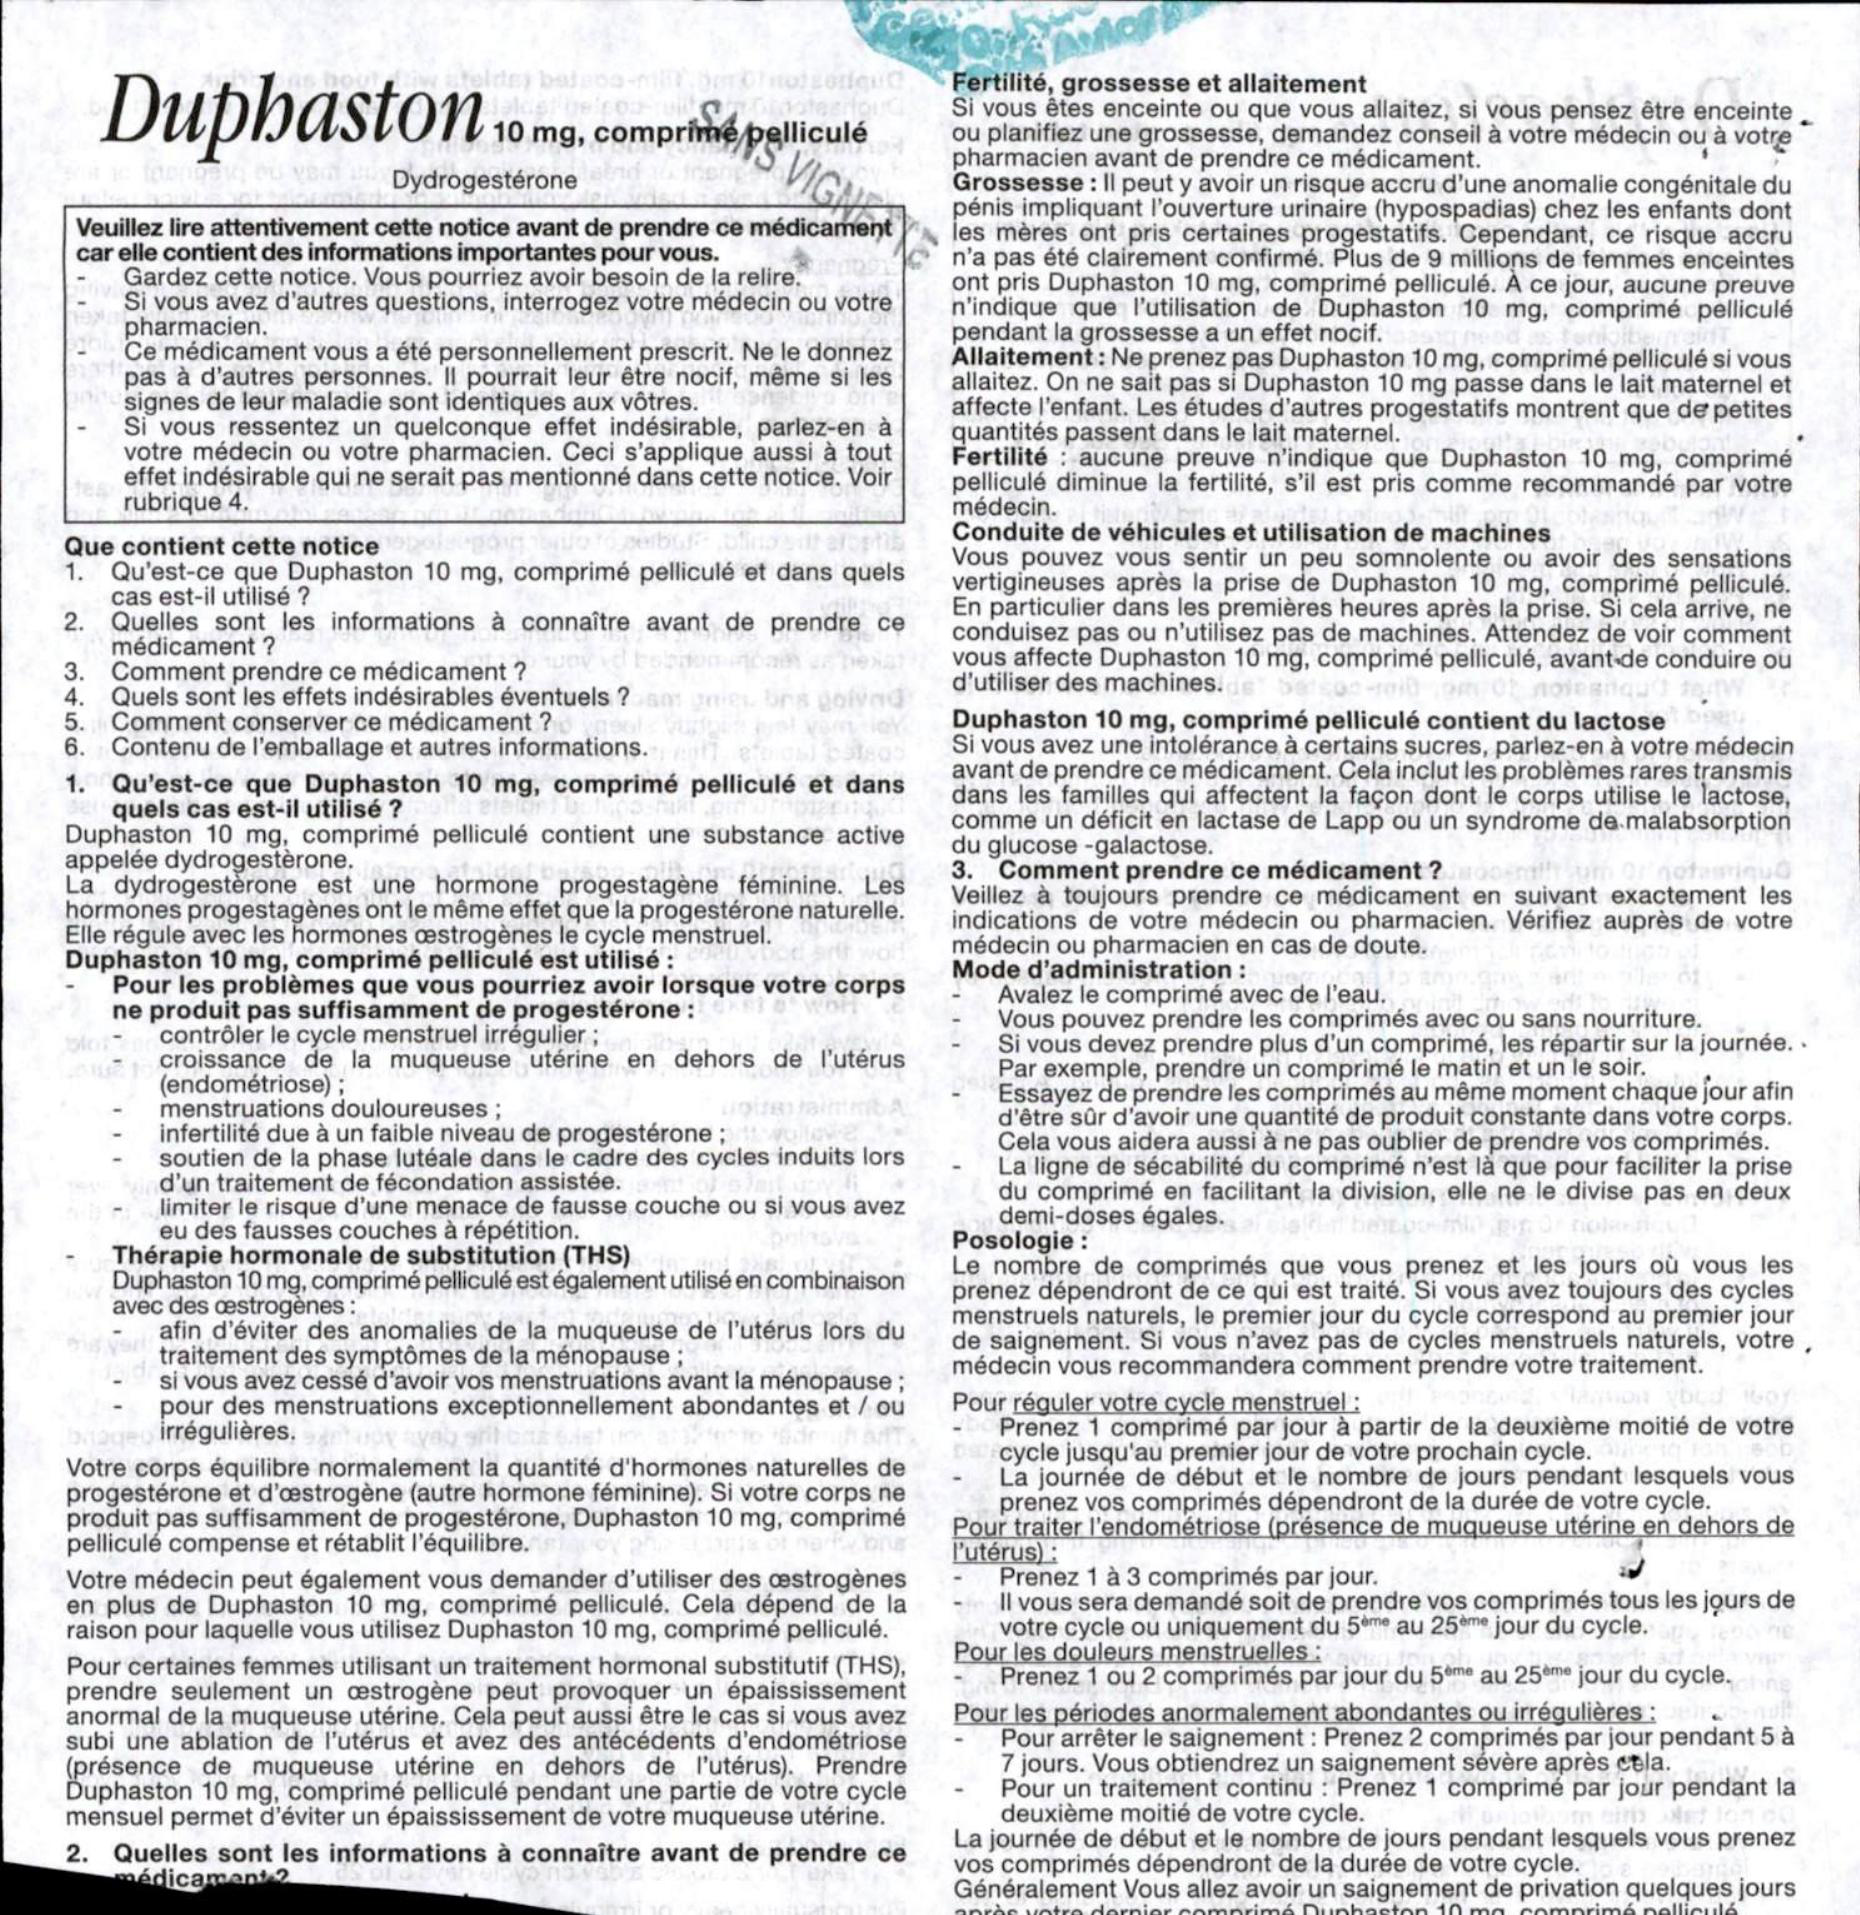

In [21]:
img

In [ ]:
path_g=r"C:\Users\Ons\Downloads\dataset\dataset\train\Bulletin_de_soin\"


In [23]:
TEMPLATES_DIR_other = r"C:\Users\Ons\Downloads\dataset\dataset\train\Other"  
TEMPLATES_DIR_Ordonnace = r"C:\Users\Ons\Downloads\dataset\dataset\train\Ordonnance"
TEMPLATES_DIR_Bulletin = r"C:\Users\Ons\Downloads\dataset\dataset\train\Bulletin_de_soin"

In [31]:
pip install torch torchvision


  Using cached torch-2.6.0-cp312-cp312-win_amd64.whl.metadata (28 kB)
  Using cached torchvision-0.21.0-cp312-cp312-win_amd64.whl.metadata (6.3 kB)
  Using cached sympy-1.13.1-py3-none-any.whl.metadata (12 kB)
Using cached torch-2.6.0-cp312-cp312-win_amd64.whl (204.1 MB)
   ---------------------------------------- 0.0/6.2 MB ? eta -:--:--
   - -------------------------------------- 0.3/6.2 MB ? eta -:--:--
   --- ------------------------------------ 0.5/6.2 MB 1.9 MB/s eta 0:00:04
   ------ --------------------------------- 1.0/6.2 MB 2.0 MB/s eta 0:00:03
   ---------- ----------------------------- 1.6/6.2 MB 2.0 MB/s eta 0:00:03
   ----------- ---------------------------- 1.8/6.2 MB 1.9 MB/s eta 0:00:03
   ------------- -------------------------- 2.1/6.2 MB 1.9 MB/s eta 0:00:03
   ---------------- ----------------------- 2.6/6.2 MB 1.8 MB/s eta 0:00:02
   ------------------ --------------------- 2.9/6.2 MB 1.8 MB/s eta 0:00:02
   -------------------- ------------------- 3.1/6.2 MB 1.7

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import os

# Vérification GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Répertoires (chemins spécifiques de ton dataset)
TEMPLATES_DIR_other = r"C:\Users\Ons\Downloads\dataset\dataset\train\Other"
TEMPLATES_DIR_Ordonnace = r"C:\Users\Ons\Downloads\dataset\dataset\train\Ordonnance"
TEMPLATES_DIR_Bulletin = r"C:\Users\Ons\Downloads\dataset\dataset\train\Bulletin_de_soin"

# Transformations des images (redimensionnement, normalisation, augmentation)
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Chargement des datasets
# Utilisation de ImageFolder pour charger les images à partir des dossiers
image_datasets = {
    'train': datasets.ImageFolder(root=r"C:\Users\Ons\Downloads\dataset\dataset\train", transform=data_transforms['train']),
    'test': datasets.ImageFolder(root=r"C:\Users\Ons\Downloads\dataset\dataset\test", transform=data_transforms['test']),
}

# DataLoader pour batch training
batch_size = 32
dataloaders = {
    'train': DataLoader(image_datasets['train'], batch_size=batch_size, shuffle=True, num_workers=4),
    'test': DataLoader(image_datasets['test'], batch_size=batch_size, shuffle=False, num_workers=4),
}

# Nombre de classes (Assure-toi que les dossiers dans "train" ont exactement 3 classes)
num_classes = len(image_datasets['train'].classes)  # Cela devrait être 3 : Other, Ordonnance, Bulletin_de_soin

# Chargement de ResNet18 pré-entraîné
model = models.resnet18(pretrained=True)

# Adapter le modèle à notre classification
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_classes)

model = model.to(device)

# Définition de la fonction de perte et de l'optimiseur
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Boucle d'entraînement
num_epochs = 10
for epoch in range(num_epochs):
    print(f"Époch {epoch+1}/{num_epochs}")
    
    # Phase d'entraînement
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in dataloaders['train']:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        _, preds = torch.max(outputs, 1)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        correct += torch.sum(preds == labels).item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total

    print(f"train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

    # Phase de test (validation sur le dataset "test")
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in dataloaders['test']:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)

            running_loss += loss.item() * inputs.size(0)
            correct += torch.sum(preds == labels).item()
            total += labels.size(0)

        epoch_loss = running_loss / total
        epoch_acc = correct / total

        print(f"test Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

print("Entraînement terminé.")

# Sauvegarde du modèle
torch.save(model.state_dict(), "modele_document.pth")
print("Modèle sauvegardé.")


C:\Users\Ons\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Ons\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\Ons/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:21<00:00, 2.18MB/s]


Époch 1/10
train Loss: 0.2052 Acc: 0.9315
test Loss: 0.4105 Acc: 0.8832
Époch 2/10
train Loss: 0.1478 Acc: 0.9540
test Loss: 0.1719 Acc: 0.9573
Époch 3/10
train Loss: 0.1131 Acc: 0.9665
test Loss: 0.1464 Acc: 0.9473
Époch 4/10
train Loss: 0.0896 Acc: 0.9715
test Loss: 0.2462 Acc: 0.9003
Époch 5/10
train Loss: 0.1008 Acc: 0.9636
test Loss: 0.1364 Acc: 0.9615
Époch 6/10
train Loss: 0.0826 Acc: 0.9718
test Loss: 0.1188 Acc: 0.9615
Époch 7/10
train Loss: 0.0778 Acc: 0.9743
test Loss: 0.3423 Acc: 0.8746
Époch 8/10
train Loss: 0.0920 Acc: 0.9715
test Loss: 0.1038 Acc: 0.9729
Époch 9/10
train Loss: 0.0803 Acc: 0.9750
test Loss: 0.1105 Acc: 0.9573
Époch 10/10
train Loss: 0.0760 Acc: 0.9736
test Loss: 0.1105 Acc: 0.9558
Entraînement terminé.
Modèle sauvegardé.


In [37]:

# Charger le modèle entraîné
def load_model(model_path, num_classes):
    model = models.resnet18(pretrained=False)  # On initialise ResNet18 sans les poids pré-entraînés
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)  # Adapter à notre classification (3 classes)
    
    model.load_state_dict(torch.load(model_path, map_location=torch.device("cuda" if torch.cuda.is_available() else "cpu")))
    model.eval()  # Mode évaluation
    return model

In [39]:
from PIL import Image

In [41]:
# Prétraitement de l'image
def preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    image = Image.open(image_path).convert("RGB")  # Convertir en RGB
    return transform(image).unsqueeze(0)  # Ajouter une dimension batch

In [43]:
# Fonction de test
def predict_image(model, image_path, class_names):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    image_tensor = preprocess_image(image_path).to(device)
    with torch.no_grad():
        outputs = model(image_tensor)
        _, predicted = torch.max(outputs, 1)
    
    return class_names[predicted.item()]  # Retourne la classe prédite


In [45]:
# Exemple d'utilisation
if __name__ == "__main__":
    class_names = ["Other", "Ordonnance", "Bulletin_de_soin"]
    model = load_model("modele_document.pth", len(class_names))
    image_path = r"C:\Users\Ons\Documents\696278-fond-noir-texture-gratuit-vectoriel.jpg"  # Remplace par le chemin de ton image
    prediction = predict_image(model, image_path, class_names)
    print(f"Classe prédite : {prediction}")

Classe prédite : Bulletin_de_soin
